<a href="https://colab.research.google.com/github/jb2467/SMRG_Video/blob/main/SMRG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hello
# Using first study as training, second as validation, could still be 60/20/20
# standarized AOI
# Rules:
##

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch as pt
import torch.nn.functional
import os
import cv2
from google.colab.patches import cv2_imshow


In [30]:
path = '/content/drive/MyDrive/SMRG/DFM 1/'

print(os.listdir(path))

subfolders = [f for f in os.listdir(path)]

videos = []

for subfolder in subfolders:
  files = os.listdir(path + '/' + subfolder)
  for file in files:
      videos.append(path + '/' + subfolder + '/' + file)
print(videos)



['Participant 16', 'Participant 19', 'Participant 20', 'Participant15']
['/content/drive/MyDrive/SMRG/DFM 1//Participant 16/P3', '/content/drive/MyDrive/SMRG/DFM 1//Participant 16/P2', '/content/drive/MyDrive/SMRG/DFM 1//Participant 19/P2', '/content/drive/MyDrive/SMRG/DFM 1//Participant 19/P3', '/content/drive/MyDrive/SMRG/DFM 1//Participant 20/P2', '/content/drive/MyDrive/SMRG/DFM 1//Participant 20/P3', '/content/drive/MyDrive/SMRG/DFM 1//Participant15/P2', '/content/drive/MyDrive/SMRG/DFM 1//Participant15/P3']


   start_time  gaze_x  gaze_y  radius  duration  end_time
0    0.033333  1146.0   358.0    20.0  0.666667  0.700000
1    0.700000  1124.0   290.0    24.0  0.466667  1.166667
2    1.166667   816.0   308.0    20.0  0.466667  1.533333
3    1.666667   816.0   272.0    21.0  0.600000  2.266667
4    2.333333  1148.0   380.0    20.0  0.666667  3.000000
5    3.000000  1134.0   296.0    22.0  0.600000  3.600000
6    3.600000  1126.0   266.0    20.0  0.066667  3.666667
7    3.666667  1206.0   362.0    24.0  0.566667  3.733333
(8, 6)


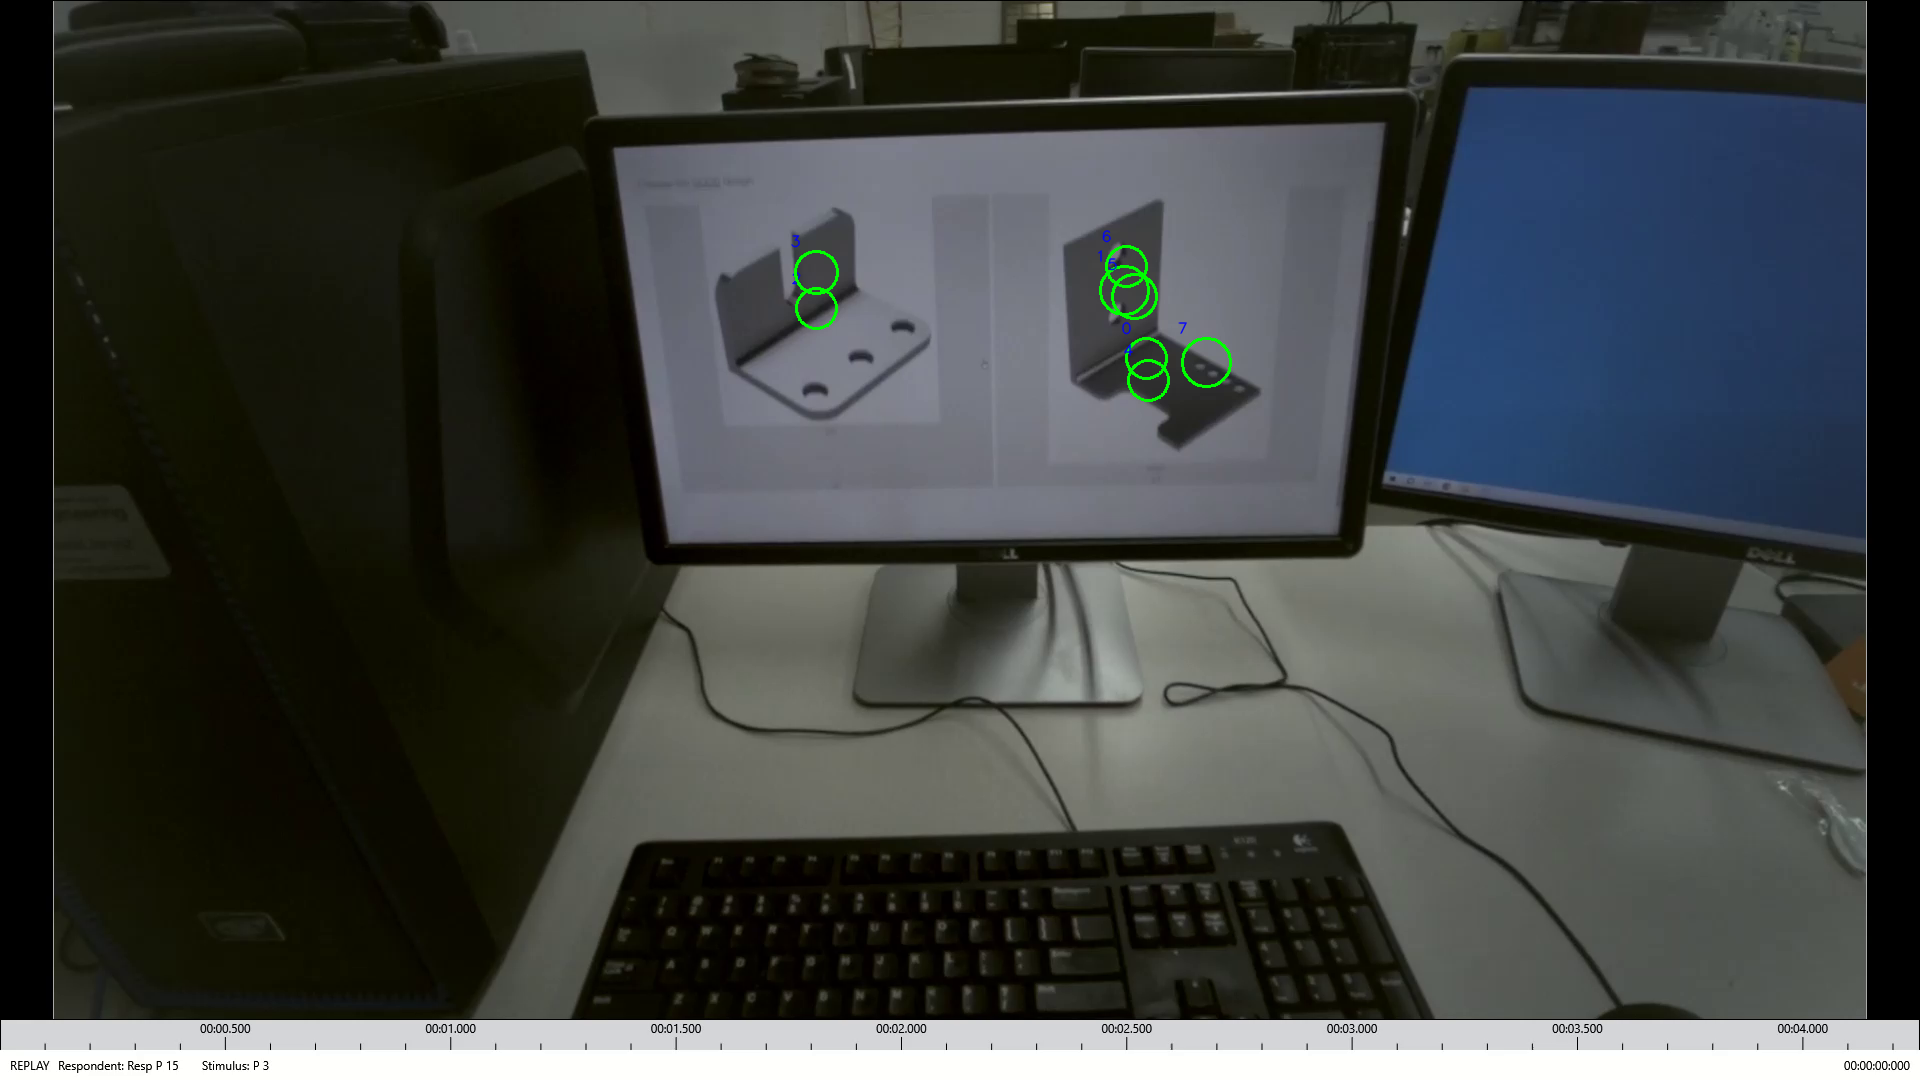

Total gaze points detected: 128


In [31]:


def analyze_eye_tracking_video(video_file, movement_threshold=10, min_fixation_duration=0.034, grace_period_frames=5):
    cap = cv2.VideoCapture(video_file)
    gaze_data = []
    prev_x, prev_y = None, None  # Track previous gaze point
    start_time = None
    grace_period_counter = 0
    raw_gaze_data = []
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_file}")
        return None

    fps = cap.get(cv2.CAP_PROP_FPS)
    time_per_frame = 1 / fps

    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        elapsed_time = frame_count * time_per_frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        circles = cv2.HoughCircles(
            gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=5, maxRadius=30
        )
        current_time_raw = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            for (x, y, r) in circles:
                grace_period_counter = 0
                raw_gaze_data.append([current_time_raw, x, y, r])
                if prev_x is not None and prev_y is not None:
                    distance_moved = np.sqrt((x - prev_x)**2 + (y - prev_y)**2)

                    if distance_moved > movement_threshold:
                        if (elapsed_time - start_time) >= min_fixation_duration:
                            fixation_duration = elapsed_time - start_time
                            end_time = start_time + fixation_duration
                            gaze_data.append([start_time, prev_x, prev_y, r, fixation_duration, end_time])

                        start_time = elapsed_time
                        prev_x, prev_y = x, y
                else:

                    start_time = elapsed_time
                    prev_x, prev_y = x, y

                break
        else:
            if prev_x is not None and prev_y is not None:

                grace_period_counter += 1

                if grace_period_counter <= grace_period_frames:
                    frame_count += 1
                    continue
                fixation_duration = elapsed_time - start_time
                if fixation_duration >= min_fixation_duration:
                    end_time = start_time + fixation_duration
                    gaze_data.append([start_time, prev_x, prev_y, r, fixation_duration, end_time])

                prev_x, prev_y = None, None

        frame_count += 1

    if prev_x is not None and prev_y is not None:
        fixation_duration = (frame_count * time_per_frame) - start_time
        if fixation_duration >= min_fixation_duration:
            end_time = start_time + fixation_duration
            gaze_data.append([start_time, prev_x, prev_y, r, fixation_duration, end_time])

    cap.release()

    df = pd.DataFrame(gaze_data, columns=['start_time', 'gaze_x', 'gaze_y', 'radius', 'duration', 'end_time'])

    merged_df = merge_similar_fixations(df)
    raw_df = pd.DataFrame(raw_gaze_data, columns=['timestamp', 'gaze_x', 'gaze_y', 'radius'])
    return merged_df, raw_df


def merge_similar_fixations(gaze_df, position_tolerance=3, time_tolerance=0.1):
    merged_data = []
    current_fixation = gaze_df.iloc[0].copy()

    for i in range(1, len(gaze_df)):
        current_row = gaze_df.iloc[i]

        same_position = (
            abs(current_fixation['gaze_x'] - current_row['gaze_x']) <= position_tolerance and
            abs(current_fixation['gaze_y'] - current_row['gaze_y']) <= position_tolerance
        )

        close_in_time = (current_row['start_time'] - (current_fixation['start_time'] + current_fixation['duration'])) <= time_tolerance

        if same_position and close_in_time:
            current_fixation['duration'] += current_row['duration']
            current_fixation['radius'] = (current_fixation['radius'] + current_row['radius']) / 2
        else:
            merged_data.append(current_fixation)
            current_fixation = current_row.copy()

    merged_data.append(current_fixation)

    merged_df = pd.DataFrame(merged_data)
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df

def display_fixations_on_video(video_file, gaze_df):
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_file}")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to read the first frame")
        return

    real_frame = frame.copy()

    for index, row in gaze_df.iterrows():
        x, y, r = int(row['gaze_x']), int(row['gaze_y']), int(row['radius'])
        cv2.circle(real_frame, (x, y), r, (0, 255, 0), 2)
        cv2.putText(real_frame, str(index), (x - r - 5, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 0, 0), 1, cv2.LINE_AA)
    cv2_imshow(real_frame)

    cap.release()


video_file = '/content/drive/MyDrive/SMRG/DFM 1/Participant15/P3/P 3 - Resp P 15.mp4'
gaze_df,raw_df = analyze_eye_tracking_video(video_file)

if gaze_df is not None:
    print(gaze_df.head(20))
    print(gaze_df.shape)
    display_fixations_on_video(video_file, gaze_df)
    print(f"Total gaze points detected: {raw_df.shape[0]}")
else:
    print("No valid gaze data to display.")


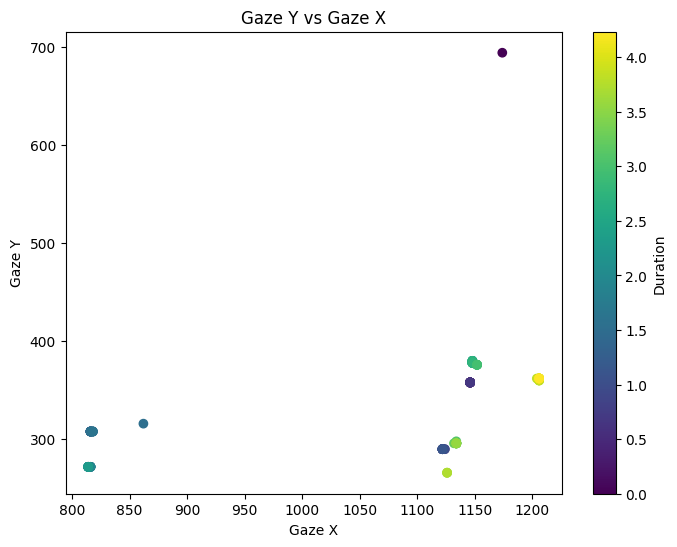

In [34]:

plt.figure(figsize=(8, 6))
plt.scatter(raw_df['gaze_x'], raw_df['gaze_y'], c=raw_df['timestamp'], cmap='viridis')
plt.xlabel('Gaze X')
plt.ylabel('Gaze Y')
plt.title('Gaze Y vs Gaze X')
_ = plt.colorbar(label='Duration')

In [ ]:
gaze_df.shape

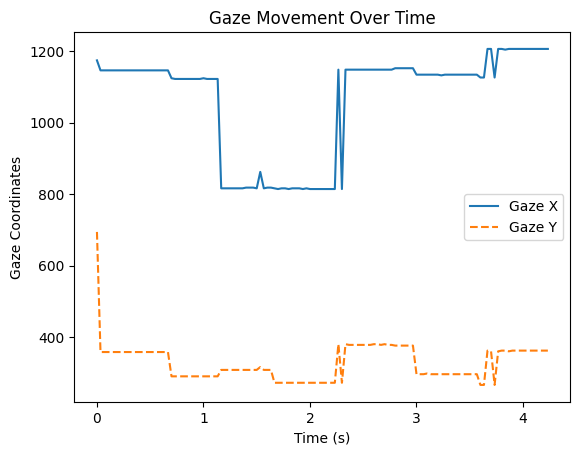

In [33]:
plt.plot(raw_df['timestamp'], raw_df['gaze_x'], label='Gaze X')
plt.plot(raw_df['timestamp'], raw_df['gaze_y'], label='Gaze Y', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Gaze Coordinates')
plt.legend()
plt.title('Gaze Movement Over Time')
plt.show()


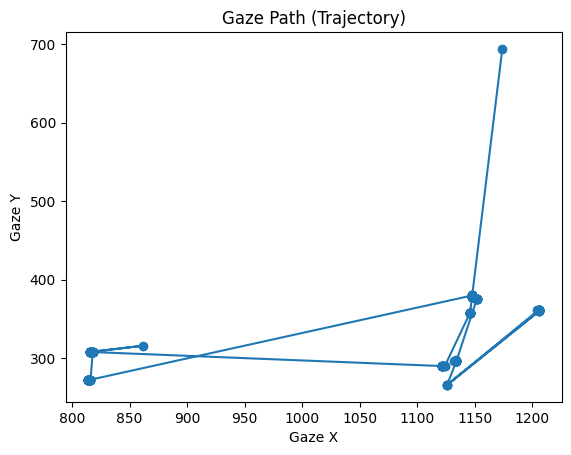

In [35]:
plt.plot(raw_df['gaze_x'], raw_df['gaze_y'], marker='o', linestyle='-')
plt.xlabel('Gaze X')
plt.ylabel('Gaze Y')
plt.title('Gaze Path (Trajectory)')
plt.show()


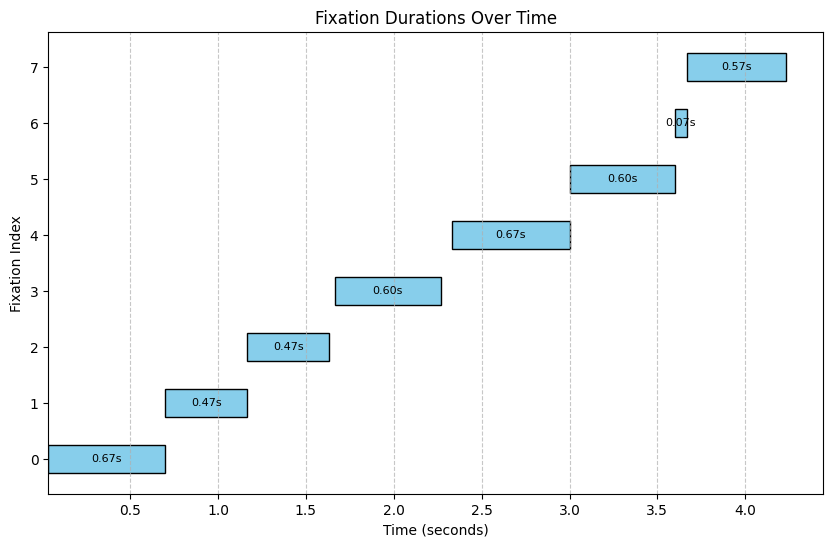

In [36]:

def plot_fixations(gaze_df):
    fig, ax = plt.subplots(figsize=(10, 6))

    for idx, row in gaze_df.iterrows():
        start = row['start_time']
        duration = row['duration']

        ax.barh(idx, duration, height=0.5, left=start, align='center', color='skyblue', edgecolor='black')
        ax.text(start + duration / 2, idx, f"{duration:.2f}s", ha='center', va='center', fontsize=8)

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Fixation Index')
    ax.set_title('Fixation Durations Over Time')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.show()

if gaze_df is not None and not gaze_df.empty:
    plot_fixations(gaze_df)
else:
    print("No valid fixation data to plot.")


sns

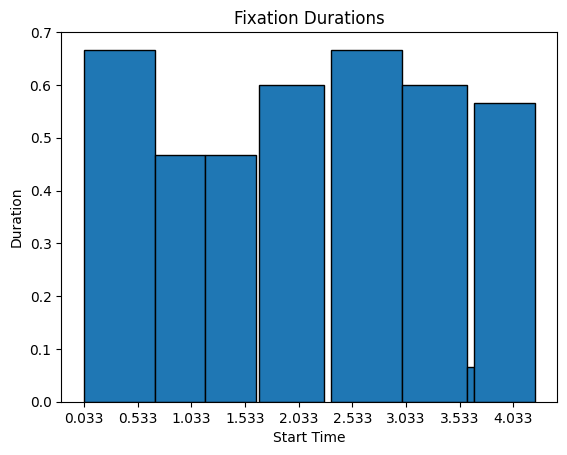

In [37]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()

start_times = gaze_df['start_time']
durations = gaze_df['duration']

ax.bar(start_times, durations, width=durations, align='edge', edgecolor='black')

ax.set_xlabel('Start Time')
ax.set_ylabel('Duration')
ax.set_title('Fixation Durations')

ax.set_xticks(np.arange(min(start_times), max(start_times) + 0.5, 0.5))

plt.show()

   timestamp  gaze_x  gaze_y  radius
0   0.033333     792     370      13
1   0.066667     796     372      13
2   0.133333     852     404      12
3   0.166667     852     404      14
4   0.200000     852     404      14
5   0.233333     852     404      18
6   0.266667     852     404      18
7   0.300000     852     404      18
8   0.300000     900     402      11
9   0.333333     852     404      18
Total gaze points detected: 182
